# Causality tests on uncertain data

In [2]:
using CausalityTools, UncertainData, Plots

┌ Info: Recompiling stale cache file /Users/code/.julia/compiled/v1.2/CausalityTools/kYD4w.ji for CausalityTools [5520caf5-2dd7-5c5d-bfcb-a00e56ac49f7]
└ @ Base loading.jl:1240
  ** incremental compilation may be fatally broken for this module **



First, generate some time series from a system of two unidirectionally coupled logistic maps with variables `x` and `y`.

## Generate some example data with known ground truth

In [3]:
npts = 200

# Define a system and record some time series after running 1000 transients
system = logistic2_unidir(c_xy = 0.5, r₁ = 3.71, r₂ = 3.8)
orbit = trajectory(system, npts - 1, Ttr = 1000);

Now, add some uncertainties to the time series for `x` and `y`.

In [4]:
# Draw from normal distributions with variable standard deviation
d = Uniform(0.001, 0.07)

x = UncertainValueDataset([UncertainValue.(Normal, x, rand(d)) for x in orbit[:, 1]])
y = UncertainValueDataset([UncertainValue.(Normal, y, rand(d)) for y in orbit[:, 2]])

# Create some time indices and add uncertainties to them
timeinds = UncertainIndexDataset([UncertainValue(Normal, i, rand()) for i = 1:npts])

# Define some `UncertainIndexValueDataset`s
X = UncertainIndexValueDataset(timeinds, x)
Y = UncertainIndexValueDataset(timeinds, y);

Plot the data

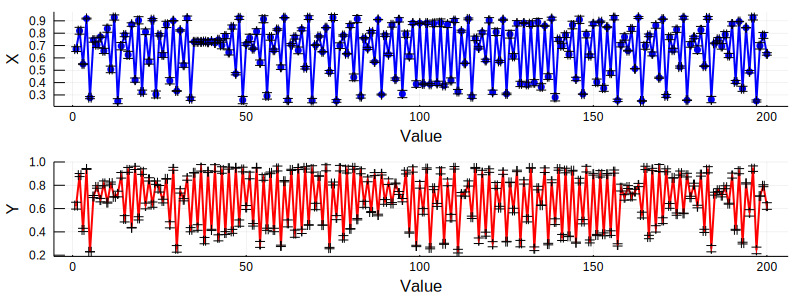

In [5]:
# Plot the data
pX = plot(lw = 0.5, c = :blue, size = (1000, 300), xlabel = "Value", ylabel = "X", label = "")
plot!(pX, mean.(X.indices), mean.(X.values), marker = stroke(0.01), lw = 2, c = :blue)
plot!(pX, X, c = :blue)

pY = plot(lw = 0.5, c = :red, size = (800, 300), xlabel = "Value", ylabel = "Y", label = "")
plot!(pY, mean.(Y.indices), mean.(Y.values), lw = 2, c = :red)
plot!(pY, Y, c = :red)

plot(pX, pY, layout = (2, 1), legend = false)

## Predictive asymmetry test

Now, define a predictive asymmetry test with default parameters (3D delay reconstruction) and a partition constructed by subdividing each coordinate axis into 5 equidistant intervals.

### Test parameters 

In [6]:
# Define causality test 
k, l, m = 1, 1, 1
ηs = -6:6
te_test = VisitationFrequencyTest(k = k, l = l, m = m, binning = RectangularBinning(5), ηs = ηs)
pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

PredictiveAsymmetryTest{VisitationFrequencyTest}(predictive_test = VisitationFrequencyTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, binning_summary_statistic = mean, estimator = VisitationFrequency(), binning = RectangularBinning(5), ηs = -6:6))

### Perform causality test

First perform the causality test in the $x \to y$ direction on 100 independent draws of `X` and `Y`. Then, 
do the same 100 separate, independent draws of `X` and `Y` in the $y\to x$ direction. 

*Note: if the uncertain values furnishing the indices have overlapping supports, then resampled values may not be ordered according to the indices*. 

In [7]:
pa_XY = [causality(X, Y, pa_test) for rep in 1:100]
pa_YX = [causality(Y, X, pa_test) for rep in 1:100];

Summarise and plot:

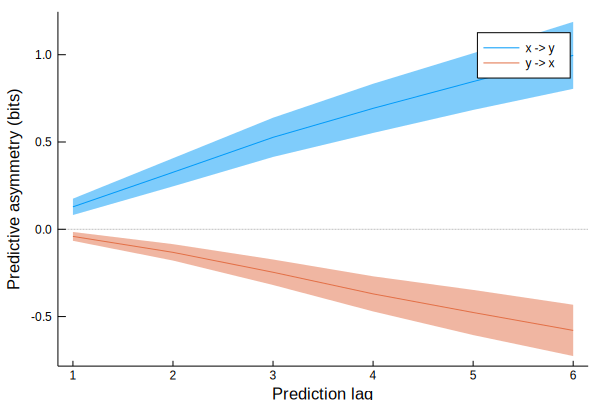

In [8]:
XY, YX = hcat(pa_XY...), hcat(pa_YX...)
mean_XY = mean(XY, dims = 2)[:, 1]
mean_YX = mean(YX, dims = 2)[:, 1]
std_XY = std(XY, dims = 2)[:, 1]
std_YX = std(YX, dims = 2)[:, 1]

plot(grid = false, xlabel = "Prediction lag", ylabel = "Predictive asymmetry (bits)")
plot!(mean_XY, ribbon = std_XY, label = "x -> y")
plot!(mean_YX, ribbon = std_YX, label = "y -> x")
hline!([0], lw = 1, ls = :dot, c = :black, α = 0.5, label = "")

We get $\mathbb{A}_{x \to y} > 0$, which indicates a directional relationship $x \to y$. On the other hand, $\mathbb{A}_{y \to x} < 0$, which does not indicate a directional relationship $y \to x$. 

Hence, the predictive asymmetry reflects the underlying coupling!